PREDICTING NEXT TIME STEP HEART FAILURE FROM SEQUENCIAL PATIENT DATA

# Imports

In [ ]:
####imports
import pandas as pd
from google.colab import files
import io
import numpy as np
from tqdm import tqdm
import pickle
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datetime import datetime
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve
# model
import os
import pickle
import numpy as np
import tensorflow as tf
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

from tensorflow.keras.models import Model, Sequential, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Input, Masking, concatenate, LayerNormalization, Add, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

from sklearn.metrics import mean_absolute_error

#from keras_multi_head import MultiHeadAttention
import seaborn as sns


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")


cpu is available.


In [ ]:
###### IMPORTING DATA IN GOOGLE COLAB #######
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['synthetic_data.csv']))
df.head(10)

#NOTE IMPORTANT THIS IS DATA OF PATIENTS OLDER THAN 40 AND FOR EACH FEATURE WE ARE GIVING THE AGE AT DIAGNOSIS

Saving synthetic_data.csv to synthetic_data.csv


,nam,ageT0,age_end,sex,Lesion,age_1stCAD,age_1stARR,age_1stVARR,age_1stPH,age_1stDIAB,...,age_allSX5,age_allSX6,age_allSX7,age_allSX8,age_allSX9,age_allSX10,age_allSX11,age_allSX12,age_allSX13,HF
0,1884,71.661537,88.588678,M,Severe,73.465811,NaN,NaN,77.994420,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2153,77.250255,88.897479,M,Valve,67.239079,NaN,NaN,71.783267,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1468,75.216748,85.942570,M,other,NaN,85.942570,NaN,55.039581,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,6820,71.886454,82.930905,M,Shunt,52.299682,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,3403,66.957054,69.821617,F,other,62.555418,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,6654,76.571826,82.973190,M,Valve,NaN,56.247117,NaN,NaN,63.289523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,2521,68.743398,76.184429,F,Valve,NaN,NaN,NaN,NaN,76.184429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,2943,84.097805,96.972426,F,Shunt,NaN,72.049700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,1948,7.663564,79.727097,F,Valve,NaN,NaN,63.653177,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,8583,67.100556,74.339450,F,Severe,56.657575,74.339450,NaN,46.798190,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Preprocessing

![picture](https://drive.google.com/uc?id=1V43wCFYm5q9LNZIWltohuUirHDyx1VSC)

The goal of this section is to transform the event-based nature of all patient data (left picture) into a discretized sequence which is a sequence such that each time-step represents patient data within the given 6-month interval (patient data on right). Additionally, we will produced its associated HF labels needed to be predicted (patient hf on right).  


In [ ]:
####### Define the Column which will be used in Sequence #######
surgeries_cols = [f'age_allSX{i}' for i in range(1, 14)]

birth_cols = ['sex', 'Lesion']

diagnoses_cols = [
    'CAD',
    'ARR',
    'VARR',
    'PH',
    'DIAB',
    'Stroke',
    'CLD',
    'CKD',
]

temporal_cols = [
    'AMI',
    'IE',
    'Sepsis'
]

ignored_cols = [
    'deces',
    'birth',
    'ADMDATE',
    'timezero',
    'age_congSX1',
    'age_congSX2',
    'age_congSX3',
    'age_congSX4',
    'age_congSX5',
    'age_congSX6',
    'age_congSX7',
    'age_congSX8',
]

diagnoses_time_col = list(map(lambda st: f'age_1st{st}', diagnoses_cols))
temporal_time_col = list(map(lambda st: f'age_1st{st}', temporal_cols))

In [ ]:
def preprocess(df):
  #df.drop(columns=ignored_cols, inplace=True)
  
  """  SURGERY """
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  surgeries = df[['nam'] + surgeries_cols].copy()
  #remove duplicates
  surgeries = surgeries.drop_duplicates()
  #transform into nam+variable+value basically verticalize 
  surgery_record = surgeries.melt(id_vars=['nam'])
  #remove NaN
  surgery_record = surgery_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  surgery_record = surgery_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  surgery_record.value = surgery_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """ Diagnosis """
  #row will all nam + diagnosis (8 columns) 
  diagnoses = df[['nam'] + diagnoses_time_col].drop_duplicates()
  #transform vertically to 3 columns (nam+vairable(8)+value(age))
  diagnoses_record = diagnoses.melt(id_vars=['nam']).sort_values(['nam', 'variable'])
  #change NaN to inf and reset index
  diagnoses_record = diagnoses_record.reset_index(drop=True).fillna(np.inf)
  #set nam as index
  diagnoses_record = diagnoses_record.set_index('nam')
  # result is a 3 column df with nam(index), variable (8 per person), value(age)
  # ['CAD','ARR','VARR','PH','DIAB','Stroke','CLD','CKD']
  
  """ temporal features """
  # 4 columns name+ 3 temporal
  temporal = df[['nam'] + temporal_time_col].drop_duplicates()
  #transform to vertical 
  temporal_record = temporal.melt(id_vars=['nam']).sort_values(['nam', 'variable'])
  #Nan -> inf
  temporal_record = temporal_record.reset_index(drop=True).fillna(np.inf)
  # set name as index
  temporal_record = temporal_record.set_index('nam')
  # round value to age
  temporal_record.value = np.round(temporal_record.value * 2.) / 2.
  # result is a 3 column df with nam(index), variable (3 per person), value(age)
  # ['AMI','IE','Sepsis']

  """ birth record """
  # 3 column -> nam + (sexe,lesion)
  birth_record = df[['nam'] + birth_cols].drop_duplicates()
  #sort by nam
  birth_record = birth_record.reset_index(drop=True).sort_values(['nam'])
  # change sexe(M or F)-> sex_F and sex_M binary variables and Lesion into 4 binary (severe,shunt,valve,other)
  birth_record = pd.get_dummies(birth_record, birth_cols)
  #let nam be the index
  birth_record = birth_record.set_index('nam')
  # result is a 7 columns df with nam(index), 6 variable (2 sexe + 4 lesion )
  # ['M','F', 'Lesion1','Lesion2','Lesion3','Lesion4']

  """ HF record """
  # 4 columns -> [nam,	HF,	ageT0,	age_end]
  hf_record = df[['nam', 'HF', 'ageT0', 'age_end']].copy()
  # fancy way of saying dropna
  non_hf_duration_threshold = 10
  only_select_hf_positive = True
  if only_select_hf_positive:
      hf_record = hf_record.dropna()
  else:
      # Now, if patient ageT0 is missing, we automatically set it to a fixed # of years
      # before the end of their studies
      hf_record.ageT0 = hf_record.ageT0.fillna(
          np.maximum(hf_record.age_end - non_hf_duration_threshold, 0)
      )
  # Set index to be nam
  hf_record = hf_record.set_index('nam')
  # Round HF age to nearest 6-month interval (0.5 year), and round up the end age
  hf_record.ageT0 = np.round(hf_record.ageT0 * 2.) / 2.
  hf_record.age_end = np.ceil(hf_record.age_end * 2.) / 2.
  #extract just unique ids
  all_patient_ids = hf_record.index.unique()
  remaining_patient_ids = []
  cms = []
  hf_labels = []
  cm_labels = []

  #For each patient create the time-series sequence
  for patient_id in tqdm(all_patient_ids):
      #one row based all based on the same patient_id
      patient_birth_rec = birth_record.loc[patient_id]
      patient_diag_rec = diagnoses_record.loc[patient_id]
      patient_hf_rec = hf_record.loc[patient_id]
      patient_temp_rec = temporal_record.loc[patient_id]
      #age 
      age_start = 40.
      age_end = patient_hf_rec.age_end.max()
      
      if age_end < 40.:
          continue
    # pass through the function below which merges each subdataframe together with respect to time intervals.
      patient_cms, patient_hf_labels = compute_patient_cms_labels(
          patient_id,
          patient_hf_rec, 
          patient_diag_rec, 
          patient_birth_rec, 
          patient_temp_rec,
          surgery_record, 
          age_start, 
          age_end
      )
      
      cms.append(patient_cms)
      hf_labels.append(patient_hf_labels)
      remaining_patient_ids.append(patient_id)
  
  """ MERGE """
  return remaining_patient_ids, cms, hf_labels

In [ ]:
def compute_patient_cms_labels(patient_id, patient_hf_rec, patient_diag_rec, patient_birth_rec,
                               patient_temp_rec, surgery_record, age_start, age_end, 
                               min_age=40.):
    patient_cms = []
    patient_hf_labels = []
    patient_cm_labels = []
    
    age_start = max(min_age, age_start)

    #here we tranform age at health event into a binary values depending on if the event occured at the age interval
    for age in np.arange(age_start, age_end+1, 0.5):        
        # Compute the birth records and permanent CMs
        single_birth_cm = patient_birth_rec.values
        single_diag_cm = np.array(patient_diag_rec.value < age, dtype=int)
        
        # Compute temporal CMs and surgery
        single_temp_cm = np.array(patient_temp_rec.value == age, dtype=int)
        single_surg_label = np.any((surgery_record.nam == patient_id) & (surgery_record.value == age)).astype(int)

        # Compute current and next HF
        hf_current = np.any((patient_hf_rec.ageT0 == age) & (patient_hf_rec.HF == 1)).astype(int)
        hf_next = np.any((patient_hf_rec.ageT0 == age + 0.5) & (patient_hf_rec.HF == 1)).astype(int)
        
        
        
        # Concatenate the CMs
        single_cms = np.concatenate([
            single_birth_cm, single_diag_cm, single_temp_cm,
            np.array([single_surg_label, hf_current, age])
        ])
        patient_cms.append(single_cms)
        patient_hf_labels.append(hf_next)


    patient_cms = np.stack(patient_cms)
    patient_hf_labels = np.array(patient_hf_labels)

    return patient_cms, patient_hf_labels

In [ ]:
# For each patient we turn event based data into sequencial data (cms = input, hf_labels = output)
ids,cms,hf_labels = preprocess(df)

"""
Note this step will take roughly 25 minutes to run (you only need to do this once)  
You can run the next cell and save the pickled files by clicking on this in google colab local files on the right and dowloading them
Then upload them and repickle them using the cell after the next to skip the preprocess steps.
"""

100%|██████████| 8428/8428 [17:32<00:00,  8.01it/s]


'\nNote this step will take roughly 25 minutes to run (you only need to do this once)  \nYou can run the next cell and save the pickled files by clicking on this in google colab local files on the right and dowloading them\nThen upload them and repickle them using the cell after the next to skip the preprocess steps.\n'

In [ ]:
#write files to local colab files
output1 = open('cms.pkl', 'wb')
pickle.dump(cms,output1)
output2 = open('ids.pkl', 'wb')
pickle.dump(ids,output2)
output3 = open('hf_labels.pkl', 'wb')
pickle.dump(hf_labels,output3)

In [ ]:
#read files from local colab files (pickled files must first be uploaded) - Link to 
infile = open('cms.pkl','rb')
cms = pickle.load(infile)
infile2 = open('ids.pkl','rb')
ids = pickle.load(infile2)
infile3 = open('hf_labels.pkl','rb')
hf_labels = pickle.load(infile3)

In [ ]:
# This is what are data now looks like for one patient
# if you want to see the whole array run this :  np.set_printoptions(threshold=10000) 
print(cms[0])

print(hf_labels[0])

#Notice that the hf_labels are the same the second to last column values  but shift over one time step (that is as we are predicting next timestep) 

[[ 0.   1.   1.  ...  0.   0.  40. ]
 [ 0.   1.   1.  ...  0.   0.  40.5]
 [ 0.   1.   1.  ...  0.   0.  41. ]
 ...
 [ 0.   1.   1.  ...  0.   0.  88.5]
 [ 0.   1.   1.  ...  0.   0.  89. ]
 [ 0.   1.   1.  ...  0.   0.  89.5]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



# Format Data 

In [ ]:
######### FORMATTING FOR SEQUENCE TO SEQUENCE BASED MODEL #########

#Addional Reading:  https://www.analyticsvidhya.com/blog/2020/08/a-simple-introduction-to-sequence-to-sequence-models/


def dataset_split(remaining_patient_ids):
    train_id, test_id = train_test_split(remaining_patient_ids, test_size=0.25, random_state=2019)
    train_id = set(train_id)
    test_id = set(test_id)
    return train_id, test_id

#SPLIT DATA INTO TEST AND TRAIN (1:3 split)
train_id, test_id = dataset_split(ids)


def train_test_preprocess(cms, labels, train_id, test_id, all_patient_ids):
    train_cms = []
    train_labels = []
    test_cms = []
    test_labels = []

    for patient_id, cm, target in tqdm(zip(all_patient_ids, cms, labels)):
        if patient_id in train_id:
            train_cms.append(cm)
            train_labels.append(target)
        else:
            test_cms.append(cm)
            test_labels.append(target)
    return train_cms, train_labels, test_cms, test_labels

#Using the slip ids, we split the data into train and test data and labels
train_cms, train_labels, test_cms, test_labels = train_test_preprocess(cms, hf_labels, train_id, test_id, ids)



8428it [00:00, 967448.32it/s]

X_train shape: (6321, 185, 20)
X_test shape: (2107, 185, 20)
y_train shape: (6321, 185, 1)
y_test shape: (2107, 185)


PADDING 
![picture](https://drive.google.com/uc?id=1aSpXlz9pjcqeFdobOTApmyKc1fa5xCVw)

The goal of padding is to transform the different lengthed sequence into the same length. Basically, making the data uniforme into order to be able to pass efficiently into our model. We padding with the value -1 so that when the model trains it will ignore this section. 

In [ ]:
#### PADDING #####
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

#Padding essentially makes all inputs sequences the same length based on the value 'maxlen' and fills the sequence with 'value=-1' which helps the training ignore that part of the sequence 
def pad(train_cms, train_labels, test_cms, test_labels):
    X_train = pad_sequences(train_cms, value=-1,dtype='float32')
    y_train = np.expand_dims(pad_sequences(train_labels), axis=-1)

    X_test = pad_sequences(test_cms, value=-1,maxlen=X_train.shape[1],dtype='float32')
    y_test = pad_sequences(test_labels,maxlen=X_train.shape[1])
    
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = pad(train_cms, train_labels, test_cms, test_labels)

#shows the input dimensions
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))


In [ ]:
# this normalizes the data using the min-max method but other can be used (note that we don't always need to scale)
#https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
"""
def min_max(x,max):
  return (x + 1)/(max + 1)

def find_max(data):
  max = 0
  for i in range(0,data.shape[0]):
    for j in range(0,data.shape[1]):
      if(data[i][j][-1]>max):
        max = data[i][j][-1]

    return max

def norm(data):
  max = find_max(data)
  for i in range(0,data.shape[0]):
    for j in range(0,data.shape[1]):
      data[i][j][-1] = min_max(data[i][j][-1],max)
  
  return data

X_train = norm(X_train)
X_test = norm(X_test)
"""

'\ndef min_max(x,max):\n  return (x + 1)/(max + 1)\n\ndef find_max(data):\n  max = 0\n  for i in range(0,data.shape[0]):\n    for j in range(0,data.shape[1]):\n      if(data[i][j][-1]>max):\n        max = data[i][j][-1]\n\n    return max\n\ndef norm(data):\n  max = find_max(data)\n  for i in range(0,data.shape[0]):\n    for j in range(0,data.shape[1]):\n      data[i][j][-1] = min_max(data[i][j][-1],max)\n  \n  return data\n\nX_train = norm(X_train)\nX_test = norm(X_test)\n'

# Models

 FIXED POSITIONAL ENCODER 

![picture](https://drive.google.com/uc?id=1MVlhQaQgfSWnc8EZDUrD4B3vDT1UVddW)

The attention layers used throughout the model see their input as a set of vectors, with no order. 
Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify visit order (i.e encode the notion of age/time)

We add "Positional Encoding" to the input vectors.
It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

If you want to learn more:

https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/#:~:text=Positional%20encoding%20describes%20the%20location,item's%20position%20in%20transformer%20models.



In [ ]:

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

Attention 

Attention has the benifit that it is fully connected and is able to account for how the each time step in a sequence impacts the others

![picture](https://drive.google.com/uc?id=1jV1OW1hOAC0Kpy7HePEKy_gt3HrayyRH)

The attention formula creates 3 set of matrices called the query, key and value, which have weights associated to them. 

The query and the kay get passed into a softmax scaled-dot-product equation. This equation yield an attention matrix of size sequence length by sequence length where each position (att_ij) in the matrix depicts the connection between (visit_i and visit_j). Thus, when we multiply this attention matix by the value matrix which is just the weighted input, we get a context-aware representation on the initial sequence called the CONTEXT VECTOR.

![picture](https://drive.google.com/uc?id=1o7au_Py37XNNaU0cmidk0bGzgECvbNQf)

It is important to note that the above describes and image is a single head attention mechanism. The multi-head comes in by applying the attention above multiple time in parallel then combining the output through a weighted average.
The intuition is that different attention head will pay attention to different patterns and relationships within the sequences thus the multi-head can pick up a deeper understanding than a single one.

MASKING:

Finally, because we are predicting future time points we need to make sure that we do not consider future time points during the training process. In order to do that we apply a masking matrix which is a square matrix of the length of the sequences where the upper diagonal triangle is set to negative infinity and the rest is zero. We add this matrix to the attention matrix during training to ensure we do not consider any relationships between a time steps and a future time step.  

![picture](https://drive.google.com/uc?id=1TqeTe7sb3kzXo9MoeJC4fqBVrL7OguIJ)


In [ ]:
##### IMPLEMENTATION OF MULTI-HEAD ATTENTION MECHANISM ##########
"""
To read more about how it works:
- https://theaisummer.com/self-attention/
- https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/
- https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853
"""

class MultiHeadAttention(tf.keras.layers.Layer):
    #initialize weights 
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    # Masking layer : https://www.tensorflow.org/guide/keras/masking_and_padding#:~:text=Masking%20is%20a%20way%20to,skipped%20when%20processing%20the%20data.
    #Basically masking ensures that the training process doesn't cheat. It ensures that the model only considers past data when predict future time points     
    def masked(self,size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        mask  = mask * -1e9
        return mask  # (seq_len, seq_len)

    def scaled_dot_product_attention(self, q, k, v, mask):
        
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)

        # add the mask to the scaled tensor.
        if mask is not None:
            matmul_qk = matmul_qk+self.masked(mask)
        attention  = matmul_qk / tf.math.sqrt(dk)
        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        #attention_weights = Activation('softmax')(attention)  
        attention_weights = tf.nn.softmax(attention, axis=-1)  # (..., seq_len_q, seq_len_k)
        output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
        return output, attention_weights
    
    
  
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def __call__(self, q, k, v,mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        #print(q.shape)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention,  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

In [ ]:
#ATTENTION MODEL

def build_attention(seq,n_layers,hidden_dim,heads,mask):
  input_dim=20  # 20 patient features
  input1= Input(shape =(None,input_dim))  #input placer we are pass data into model 
  x = input1+positional_encoding(seq,input_dim)[:, :seq, :] #apply positional encoder

  fn1, att = MultiHeadAttention(d_model=hidden_dim, num_heads=heads)(q=x,k=x,v=x,mask=mask) # apply multihead attention layer
  fn1 = LayerNormalization()(fn1) # layernormalization
  fn1 = Dropout(0.2)(fn1) #dropout layer
  out = Dense(1, activation='sigmoid')(fn1) # dense layer to predict next time step
  model = Model(inputs=input1,outputs=out) 
    
  return model

  #Try adding to the model

    #batch normalization
    # convolutional layer are sometimes used

    #WE ARE ABLE TO CREATE AN ATTENTION BLOCK BY COMBINING THE ATTENTION LAYER WITH:

      #fn1 = LayerNormalization()(fn1) # layernormalization
      #fn1 = Dropout(0.2)(fn1) #dropout layer
      #feed forward network 
      #residual connections
      #we can create a for loop to have multiple attention blocks

    # Some ideas: 
    #https://towardsdatascience.com/attention-for-time-series-classification-and-forecasting-261723e0006d
    #https://towardsdatascience.com/time-series-forecasting-with-deep-learning-and-attention-mechanism-2d001fc871fc
    #look up attention based models!!!


RNN, LSTM, GRU MODELS 

These models are considered the norm in modelling sequences. 

RNN: 

Process sequential data by accounting for the current input and also what has been learned from previous inputs.

The advantage is that it accounts for order and previous inputs in a meaningful way. The disadvantages are Processing long sequences can yield memory and computation issues this is often called the vanishing gradient problem.

This is how it works: 

<img src="https://drive.google.com/uc?id=1BXg4eSDFpMl5X8ZaKXo_YQ_9AfMge_AZ" width="750" align="center">

Each X_i represents a time step. W is the weights that filter inputs, a is the activation of the hidden layer (a combination of weighted input and the previous hidden state), and b is the output of the hidden layer after it has been transformed, or squashed, using a rectified linear or sigmoid unit. The b_i value represents the hidden state of what was learnt in previous time steps.

The vanishing gradient problem mentioned above occurs when the sequence is long (i.e. many X_i). What happens in this case is that the gradient shrink leading to it because difficutl to update the weights and biases at the early section of the sequence (i.e at X_0, X_1). Thus, lets say that a patient had a surgery at age 1, the model would not effectively learn the correlation between that and a Heart Failure at the age of 40. To overcome this, reseachers developed the LSTM and GRU blocks.

LSTM:

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Above link give a great walk through of how LSTM works.
Here's a quick illustration of how the LSTM Block works:


![picture](https://drive.google.com/uc?id=1Z9gmE_kKEAVz4LJh18_0dHHYqL4ZtcLF)

In the block above, 

- Red Box (Forget gate):  Purpose of the red box is to learn what to forget from the previous and current states. It is trained to apply a sigmoid activation layer which outputs value near 0 when the input is deemed irrelevant to predictions and 1 if important.

- Pink Box (Update gate):  Purpose of the pink box is to determine what new information should be added to the networks long-term memory (cell state), given the previous hidden state and new input data. We call it the update section.

- Yellow Box (Output gate): Purpose of the pink box is to decide the new hidden state. To decide this, we will use three things; the newly updated cell state, the previous hidden state and the new input data. Note that this hidden state get trained to output important information specifically about the predictive task where as the new cell state is a representation of the entire sequence at that time step.

As each gate decides the relevancy of information that is stored in the cell and hidden states, when back propagating from cell to cell, the passed error is as close to 1 as possible. This ensures that there is no vanishing of gradients. If you understand residual networks it works in a similar way as the new cell state connects the layers inside the cell with information that stabilizes the propagation of error.

GRU:

The GRU also tries to solve the vanishing gradient problem. GRUs solve this problem through the use of two gates, the update gate and reset gate. These gates decide what information is allowed through to the output and can be trained to retain information from farther back. 
Here a link to how it works: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

Here's a diagram of the difference between LSTM and GRU:

![picture](https://drive.google.com/uc?id=1aLIWWmRsmhlbs2aYti5EoDyNpU7UcqZu)

The GRU splits the learning into twwo gates, the reset and update gates. 
- Reset gate: Used to decide how much past information to forget and is responsible for the short-term memory of the network i.e the hidden state.
- Update gate:  Used similar to the forget and input gate of an LSTM. It decides what information to throw away and what new information to add. It serves as the long-term memory update.

In all, GRUs has fewer operations; therefore, they are faster to train then LSTMs and less complex. 
There isn’t a clear winner which one is better. Researchers usually try both to determine which one works better for their use case.


It is important to mention that as more experiments were performed with the LSTMs and GRUs there is a certain degree of complexity where this network stops being able to learn. Generally it goes to the thousand time steps before it happens which is already pretty good. However, deep understanding is needed sometimes and has motivated a shift to using attention based models such as the Transformer.



To read more about the differences between lstm and gru and rnn:

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
https://www.analyticsvidhya.com/blog/2022/01/tutorial-on-rnn-lstm-gru-with-implementation/
https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573


In the models below you can add feed forward networks before the RNN layers and also you can add additional RNN layer using for loops


In [ ]:
#GRU Model

def build_gru_model(n_layers = 2, hidden_dim=64):
    input1 = Input(shape=(None,20)) #input placer we are pass data into model 
    mask1 = Masking(-1)(input1) #masking to ensure the training does not look into the future
    layers = GRU(hidden_dim, return_sequences=True)(mask1) #apply GRU layer
    out = Dense(1, activation = 'sigmoid')(layers) # dense layer to predict next time step
    
    model = Model(inputs=input1, outputs = out)
    return model

In [ ]:
#LSTM Model
def build_lstm_model(n_layers = 2, hidden_dim=64):
    input1 = Input(shape=(None,20))
    mask1 = Masking(-1)(input1) #masking to ensure the training does not look into the future
    layers = LSTM(hidden_dim, return_sequences=True)(mask1) #apply LSTM layer
    out = Dense(1, activation = 'sigmoid')(layers) # dense layer to predict next time step
    
    model = Model(inputs=input1, outputs = out)
    return model

In [ ]:
#RNN Model
def build_RNN_model(n_layers = 2, hidden_dim=64):
    input1 = Input(shape=(None,20))
    mask1 = Masking(-1)(input1) #masking to ensure the training does not look into the future
    layers = SimpleRNN(hidden_dim, return_sequences=True)(mask1) #apply RNN layer
    out = Dense(1, activation = 'sigmoid')(layers) # dense layer to predict next time step
    
    model = Model(inputs=input1, outputs = out)
    return model



# Training

Since each patient will only have a few recorded HF hospitalizations throughout their entire life, the dataset label is heavily skewed towards negative examples, which may mislead the model to achieve a high accuracy at the cost of precision. 
    
FOCAL LOSS overcome this limitation by added a weighted value on top of a normal cross entropy loss

References: https://arxiv.org/pdf/1708.02002.pdf

Learn more: https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7


In [ ]:
def binary_focal_loss(gamma=2., alpha=.25):

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed

In [ ]:
epoch_num = 10 #play around
valid = 0.15 

In [ ]:
#train GRU model
gru = build_gru_model()
gru.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)],optimizer=Adam(learning_rate=1e-2),metrics = [tf.keras.metrics.Precision()])
#model.summary()
train_hist = gru.fit(
            x=X_train, 
            y=y_train, 
            epochs=epoch_num, 
            verbose=0,
            validation_split=valid
        )

In [ ]:
#train LSTM model
lstm = build_lstm_model()
lstm.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)],optimizer=Adam(learning_rate=1e-2),metrics = [tf.keras.metrics.Precision()])
#model.summary()
train_hist = lstm.fit(
            x=X_train, 
            y=y_train, 
            epochs=epoch_num, 
            verbose=0,
            validation_split=valid
        )

In [ ]:
#train attention model
attention = build_attention(X_train.shape[1],1,64,8,X_train.shape[1])
attention.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)],optimizer=Adam(learning_rate=1e-2),metrics = [tf.keras.metrics.Precision()])
#model.summary()
train_hist = attention.fit(
            x=X_train, 
            y=y_train, 
            epochs=epoch_num, 
            verbose=0,
            validation_split=valid
        )

In [ ]:
#train RNN model
rnn = build_RNN_model()
rnn.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)],optimizer=Adam(learning_rate=1e-2),metrics = [tf.keras.metrics.Precision()])
#model.summary()
train_hist = rnn.fit(
            x=X_train, 
            y=y_train, 
            epochs=epoch_num, 
            verbose=0,
            validation_split=valid
        )


# Evaluate

In [ ]:
# Calculate prediction and return them with the true labels
def compute_flat_pred(model, X_test, test_labels):
    with tf.device('/cpu:0'):
        y_pred = model.predict(X_test)
    
    y_pred = np.squeeze(y_pred).tolist()
    
    true_test = []
    pred_test = []

    for pred, true in zip(y_pred, test_labels):
        pred_test.extend(pred[-len(true):])
        true_test.extend(true)

    true_test = np.array(true_test)
    pred_test = np.array(pred_test)
    #print(pred_test.dtype)
    
    
    return true_test, pred_test

METRICS:

Compute metrics we want to evaluate (area under the precision recall curve and area under the receiver operating curve)

Area Under the Precision Recall Curve (AUPRC):
- How is it calculated:  Evaluate the predicted probabilities against the actual binary labels, to find the Precision and Recall at different thresholds. Find the area under the curve
- Ideal value:  Much Greater than the Fraction of Positive in testing set 
  (i.e all Heart Failures/ all Time Steps = 0.013) 
- Clinical Significance: For a clinical risk prediction model, the AUPRC tells you if the real diagnoses were identified (recall) without the negative diagnoses being classified as positive (precision)


Area Under the Receiver Operating Characteristic (AUROC):
- How is it calculated:  Evaluate the predicted probabilities against the actual binary labels, to find the TFR and FPR at different thresholds. Find the area under the curve
- Ideal value:  >0.8 is good performance with baseline = 0.5
- Clinical Significance: For a clinical risk prediction model, the AUROC tells you the probability that a randomly selected patient who experienced an event will have a higher predicted risk score than a randomly selected patient who did not experience an event.


In [ ]:
def pr_roc(model, test_cms, test_labels):
    y_test_flat, y_pred = compute_flat_pred(model, X_test, test_labels)
    precision, recall, thresh_pr = precision_recall_curve(y_test_flat, y_pred)
    ap = average_precision_score(y_test_flat, y_pred)
    fpr, tpr, thresh_roc = roc_curve(y_test_flat, y_pred)
    roc = roc_auc_score(y_test_flat, y_pred)
    return precision, recall, thresh_pr, ap, fpr, tpr, thresh_roc, roc


def plot_roc(fpr, tpr, roc):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f' (AUC={roc:.4f})')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate(TPR)')
    plt.legend()

def plot_pr(precision, recall, ap):
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, label=f'(AUC={ap:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()


Text(0, 0.5, 'True Positive Rate(TPR)')

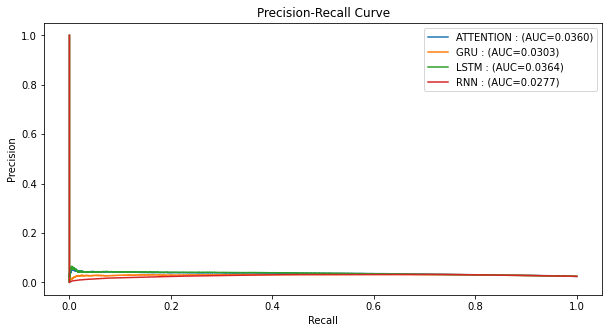

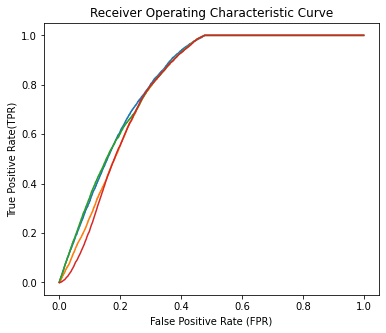

In [ ]:
#attention
precision, recall, thresh_pr, ap, fpr, tpr, thresh_roc, roc= pr_roc(attention,X_test,y_test)

#GRU
precision1, recall1, thresh_pr1, ap1, fpr1, tpr1, thresh_roc1, roc1= pr_roc(gru,X_test,y_test)

#LSTM
precision2, recall2, thresh_pr2, ap2, fpr2, tpr2, thresh_roc2, roc2= pr_roc(lstm,X_test,y_test)

#RNN
precision3, recall3, thresh_pr3, ap3, fpr3, tpr3, thresh_roc3, roc3= pr_roc(rnn,X_test,y_test)

#Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label=f'ATTENTION : (AUC={ap:.4f})')
plt.plot(recall1, precision1, label=f'GRU : (AUC={ap1:.4f})')
plt.plot(recall2, precision2, label=f'LSTM : (AUC={ap2:.4f})')
plt.plot(recall3, precision3, label=f'RNN : (AUC={ap3:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()


#Receiver Operating Characteristic Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ATTENTION : (AUC={roc:.4f})')
plt.plot(fpr1, tpr1, label=f'GRU : (AUC={roc1:.4f})')
plt.plot(fpr2, tpr2, label=f'LSTM : (AUC={roc2:.4f})')
plt.plot(fpr3, tpr3, label=f'RNN : (AUC={roc3:.4f})')
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)')



In [ ]:
print(f'ATTENTION : (AUC={roc:.4f})')
print(f'GRU : (AUC={roc1:.4f})')
print(f'LSTM : (AUC={roc2:.4f})')
print(f'RNN : (AUC={roc3:.4f})')

ATTENTION : (AUC=0.8212)
GRU : (AUC=0.8062)
LSTM : (AUC=0.8202)
RNN : (AUC=0.8003)


NOTE: This is synthetic data thus the predictive accuracy should not be great however, aimilar models were tested and yield benchmark accuracy on real data is this paper: https://journals.plos.org/plosone/article/authors?id=10.1371/journal.pone.0245177


# Interpret the output of attention model

Two key important advantages of using attention based models:

1. Just like in logistic regression we can examine the coefficients in front of each variable to assess their importance in the predictive task, we can examine the attention matrix to assess the relationship and importance between time steps. This is commonly done in Natural Language Processing task to see which word are important to consider to complete a sentence. For example, below to predict the word in red, we are paying more 'attention' to word in blue.

![picture](https://drive.google.com/uc?id=1aYNBKjCwyfIuxYbxK3LSDjtmpSvb-XlL)

2. The context vector described above allows us to output Heart Failure as a function of time, in the form of a visualized trajectory showed below. The context vector is a deep representation of a give patient medical history with repect to the target (Heart Failure). In a lot of NLP, problems the context vector is use to help computers understand paragraphs for many problems, such as translation, sentence completion, Ambiguity, speech recognotion and many others.



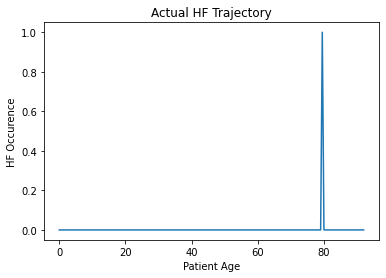

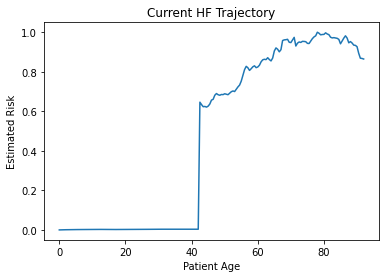

In [ ]:
def graphs(model,patient,X_test,y_test):
  length_seq = X_test[patient].shape[0]

  #### Graph Actual HF history ######
  x = []
  value = 0
  for i in range(length_seq):
    x.append(value)
    value = value+0.5
  plt.plot(x,y_test[patient])
  plt.xlabel('Patient Age')
  plt.ylabel('HF Occurence')
  plt.title('Actual HF Trajectory')
  plt.show()


  #### Estimated Acutal HF history ######
  one = model.predict(X_test[patient].reshape((1,length_seq,20)))
  #y = (one - np.min(one)) / (np.max(one) - np.min(one)) # if you want to scale to 0,1 probability
  x = []
  value = 0
  for i in range(length_seq):
    x.append(value)
    value = value+0.5
  plt.plot(x,one[0])
  plt.xlabel('Patient Age')
  plt.ylabel('Estimated Risk')
  plt.title('Current HF Trajectory')
  plt.show()

  #The graph shows that the predicted risk peaks around the actual HF event
  #Note: we only have data for each patient after the age of 40 that is why it is at zero before 40

patient = 0 #pick a patient from test set
graphs(attention,patient,X_test,y_test)

In [ ]:
# Threshold is the value at the prediction would assign a HF event. 
#Thus on the graph above when the line reaches above the threshold value it implies that there is high risk of HF

def threshold(model,x,y):
  #compute threshold 
  with tf.device('/cpu:0'):
      y_pred_hf = model.predict(x)
  y_pred_hf = y_pred_hf.squeeze()
  hf_thresh = np.extract(y, y_pred_hf).mean()
  return hf_thresh

hf_thresh = threshold(attention,X_test,y_test)
hf_thresh

0.14282021

# Addional Info: Classification SetUp 

In [ ]:
### For classification problems
"""
If you wanted to turn the seq2seq model into a classification probelm we have create 
minisequences and create a label which is the next HF label, i.e input = 10 times steps from 0 to i  and output = 1 HF value at i+1
"""

def trim(x):
  z = []
  window_size = 60
  for i in x:
    if(i.shape[0]>=window_size):
      for j in range(0,i.shape[0]-window_size-1):
        z.append(i[j:window_size+j])   
  return np.array(z)

train_cms, train_labels, test_cms, test_labels

x1 = trim(train_cms)
y1 = trim(train_labels)
x2 = trim(test_cms)
y2 = trim(test_labels)


def transform_classify(y):
  z = []
  for i in y:
    z.append(i[-1])   
  return np.expand_dims(np.array(z), axis=1)

y1 = transform_classify(y1)
y2 = transform_classify(y2)
print(y1.shape)
print(y2.shape)
#Padding essentially makes all inputs sequences the same length based on the value 'maxlen' and fills the sequence with 'value=-1' which helps the training ignore that part of the sequence 
def pad(train_cms, train_labels, test_cms, test_labels):
    X_train = pad_sequences(train_cms, value=-1,dtype='float32')
    y_train = np.expand_dims(pad_sequences(train_labels), axis=-1)

    X_test = pad_sequences(test_cms, value=-1,maxlen=X_train.shape[1],dtype='float32')
    y_test = np.expand_dims(pad_sequences(test_labels), axis=-1)
    
    return X_train, y_train, X_test, y_test
    
x1, y1, x2, y2 = pad(x1, y1, x2, y2)

#shows the input dimensions
print("X_train shape: {}".format(x1.shape))
print("X_test shape: {}".format(x2.shape))
print("y_train shape: {}".format(y1.shape))
print("y_test shape: {}".format(y2.shape))

(181933, 1)
(61076, 1)
X_train shape: (181933, 60, 20)
X_test shape: (61076, 60, 20)
y_train shape: (181933, 1, 1)
y_test shape: (61076, 1, 1)


TRY TO IMPLEMENT A MODEL TO CLASSIFY THESE SEQUENCES:

Try to find the accuracy as well, any accuracy is good but try to get a value for it to see that it works

This notebook was made by Harry Moroz.

If you have questions or want me to look over an answer to the above problem  send email to: 

harry.moroz@mail.mcgill.ca
